In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.preprocessing import PowerTransformer, LabelEncoder, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

# Understand the Data

In [45]:
df = pd.read_csv('synthesis_data.csv')
df.head()

,Temp,Pulse,RR,Spo2,BW,RS,CRP,CVS,CNS,PA,SC,WL,CRY,GRUNTING,Icterus,Diagnosis
0,99.266984,143.380514,30.880283,-0.308840,1.274040,0.527976,0.152285,1,2,0,0,0,0,2,0,RDS
1,99.472473,159.233264,57.958376,-0.869105,1.295827,0.529462,0.032064,1,0,0,0,0,0,0,0,RDS
2,100.037363,140.415164,24.311105,-0.892388,2.207575,0.527460,0.372925,1,6,0,0,0,0,0,0,AGE WITH SEVERE DEHYDRATION
3,98.019616,159.257506,48.973909,-1.178824,1.301873,0.159019,-0.061091,1,0,0,0,0,3,0,0,RDS
4,98.655776,146.882017,31.164539,0.618098,2.210081,0.528826,-1.834269,1,3,0,1,1,3,0,0,HYPERBILIRUBINEMIA


In [149]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_with_const = add_constant(df)

vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]

vif_data

,Variable,VIF
0,Temp,1.471409
1,Pulse,1.694002
2,RR,1.416585
3,Spo2,1.508888
4,BW,2.033403
5,RS,1.356300
6,CRP,1.598737
7,CVS,1.532353
8,CNS,1.163659
9,PA,2.665944


In [5]:
df.shape.

(50000, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Temp       50000 non-null  float64
 1   Pulse      50000 non-null  float64
 2   RR         50000 non-null  float64
 3   Spo2       50000 non-null  float64
 4   BW         50000 non-null  float64
 5   RS         50000 non-null  float64
 6   CRP        50000 non-null  float64
 7   CVS        50000 non-null  int64  
 8   CNS        50000 non-null  int64  
 9   PA         50000 non-null  int64  
 10  SC         50000 non-null  int64  
 11  WL         50000 non-null  int64  
 12  CRY        50000 non-null  int64  
 13  GRUNTING   50000 non-null  int64  
 14  Icterus    50000 non-null  int64  
 15  Diagnosis  50000 non-null  object 
dtypes: float64(7), int64(8), object(1)
memory usage: 6.1+ MB


In [7]:
df.describe()

,Temp,Pulse,RR,Spo2,BW,RS,CRP,CVS,CNS,PA,SC,WL,CRY,GRUNTING,Icterus
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,98.797607,148.706141,34.121139,0.145589,2.225971,0.329810,0.033293,0.591940,0.786220,0.051740,0.212260,0.080360,0.98370,0.418620,0.210460
std,1.043529,12.559965,11.491798,1.004403,0.509356,0.218001,0.980103,0.491479,1.354295,0.221504,0.408912,0.271852,1.35882,0.796486,0.533303
min,98.000000,124.000000,10.046491,-2.759179,1.100000,0.014930,-2.282817,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,98.119826,140.243648,25.479414,-0.859228,2.207338,0.105766,-0.719409,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,98.501028,146.893162,30.089897,0.306150,2.210809,0.527365,0.075355,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,98.798461,154.373206,38.649261,1.076630,2.516734,0.529048,0.878684,1.000000,1.000000,0.000000,0.000000,0.000000,3.00000,0.000000,0.000000
max,104.095786,187.096594,77.990763,2.365506,3.500000,0.529462,2.450261,1.000000,6.000000,1.000000,1.000000,1.000000,3.00000,2.000000,2.000000


In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum()

Temp         0
Pulse        0
RR           0
Spo2         0
BW           0
RS           0
CRP          0
CVS          0
CNS          0
PA           0
SC           0
WL           0
CRY          0
GRUNTING     0
Icterus      0
Diagnosis    0
dtype: int64

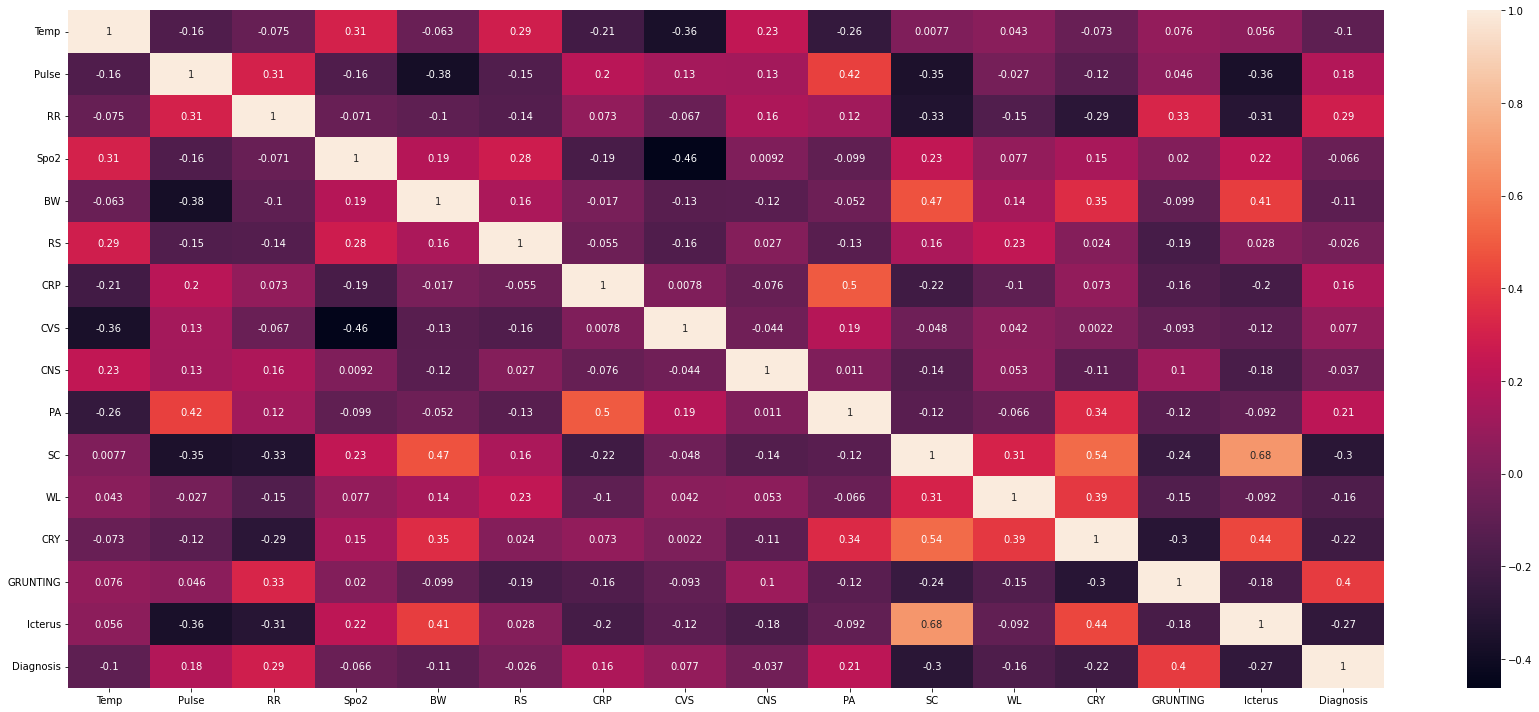

In [58]:
plt.figure(figsize = (24,10))
sns.heatmap(df.corr(), annot=True)
plt.tight_layout()
plt.show()

# Feature Engineering

In [96]:
label_encoder = LabelEncoder()
df['Diagnosis'] = label_encoder.fit_transform(df['Diagnosis'])

In [46]:
scaler = MinMaxScaler()
columns_to_normalize = ['Temp', 'Pulse','RR', 'BW']
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [47]:
df['Temp'] = df['Temp'] ** (1/3)
df['RR'] = df['RR'] ** (1/3)
df['Pulse'] = df['Pulse'] ** (1/3)

In [52]:
def cap_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = np.clip(df[column], lower_bound, upper_bound)

columns_to_cap = ['Temp', 'RR', 'BW', 'Pulse', 'Spo2', 'CRP']

cap_outliers_iqr(df, columns_to_cap)

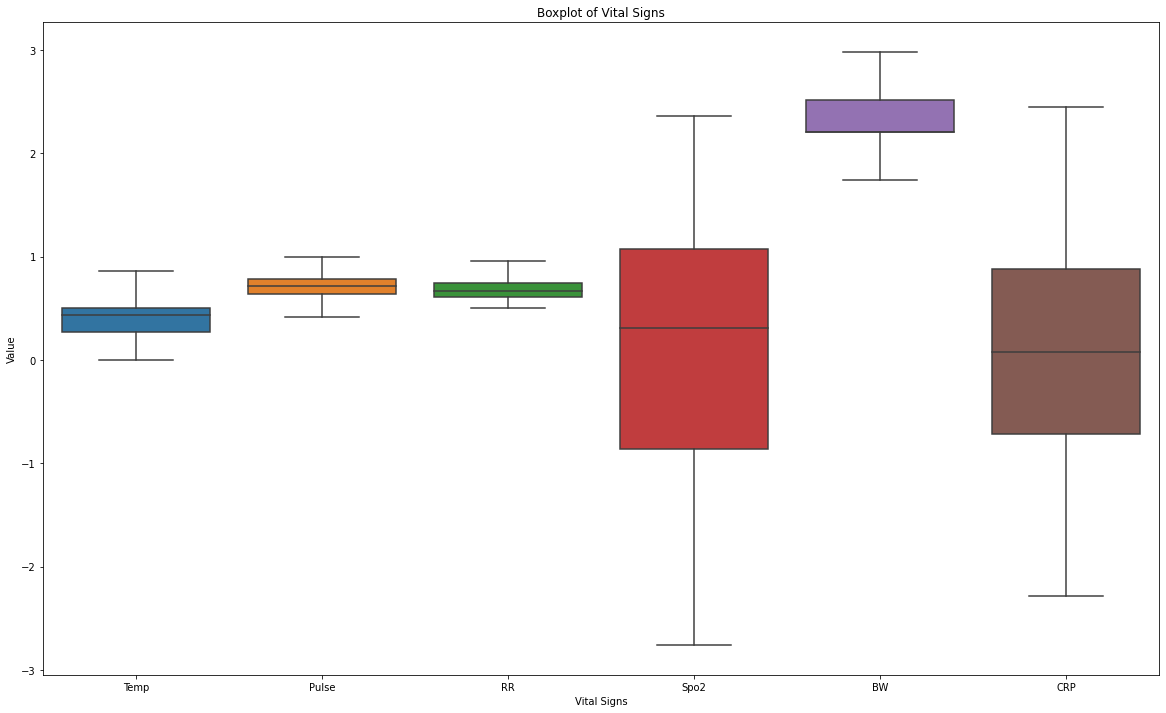

In [53]:
columns_to_plot = ['Temp', 'Pulse', 'RR', 'Spo2', 'BW', 'CRP']

plt.figure(figsize=(20, 12))
sns.boxplot(data=df[columns_to_plot])
plt.title('Boxplot of Vital Signs')
plt.xlabel('Vital Signs')
plt.ylabel('Value')
plt.show()

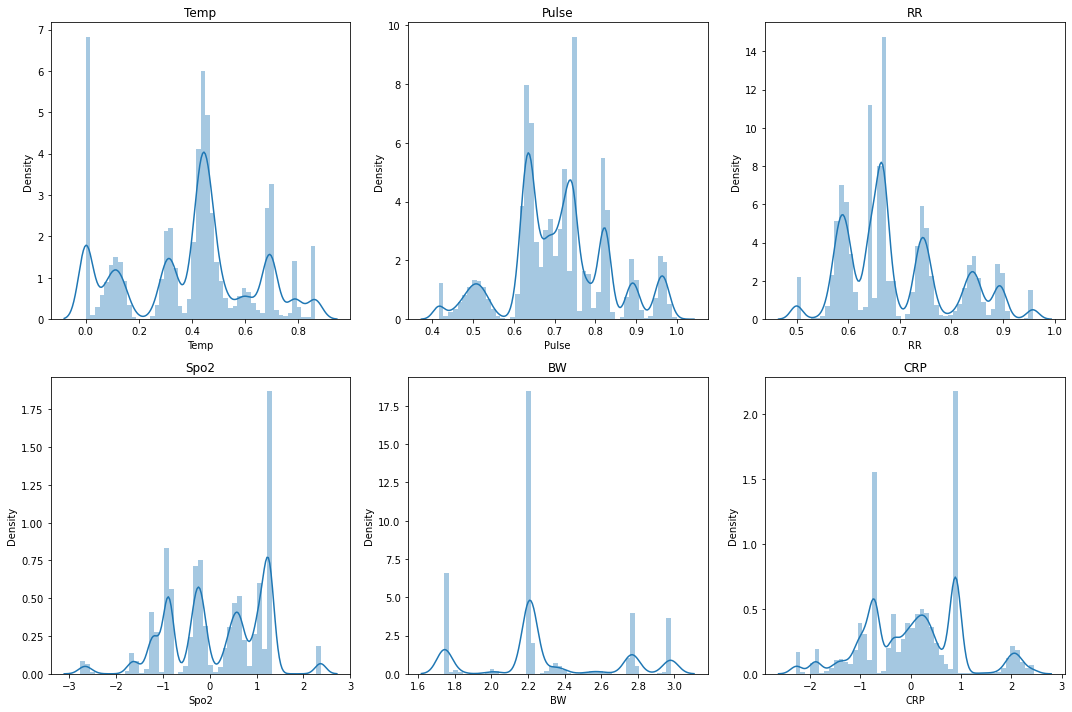

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
columns_to_plot = ['Temp', 'Pulse', 'RR', 'Spo2', 'BW', 'CRP']

for i, column in enumerate(columns_to_plot):
    sns.distplot(df[column], ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

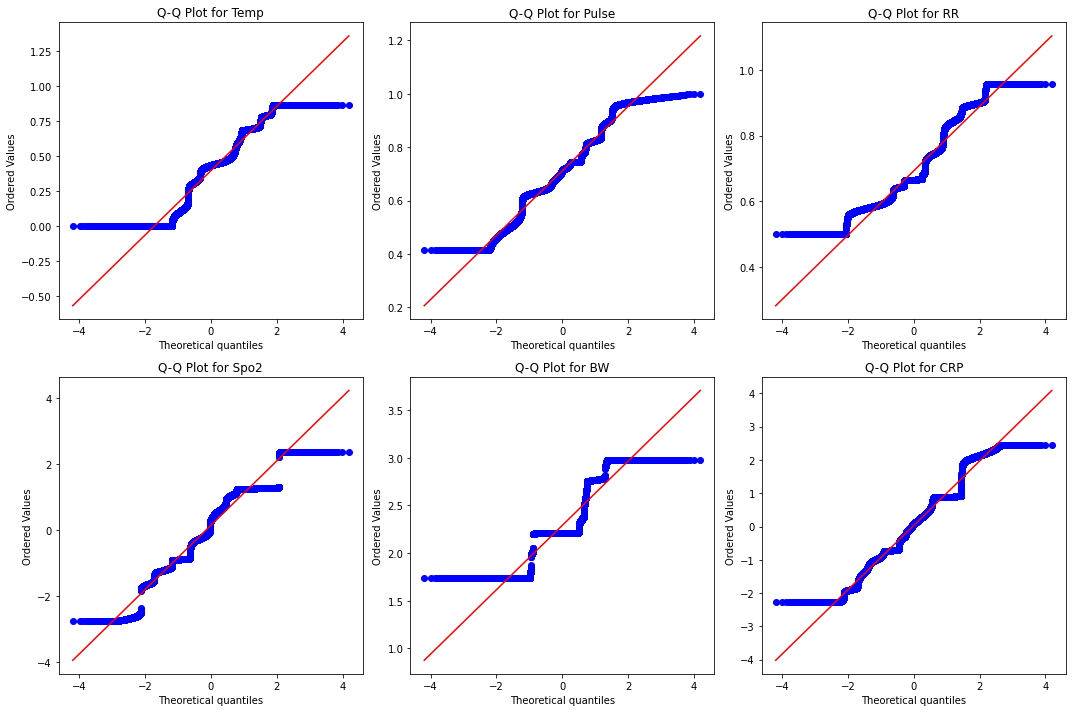

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axes = axes.flatten()
columns_to_plot = ['Temp', 'Pulse', 'RR', 'Spo2', 'BW', 'CRP']

for i, column in enumerate(columns_to_plot):
    stats.probplot(df[column], plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {column}')

plt.tight_layout()
plt.show()

In [ ]:
def growth_milestone(weight_change):
    if weight_change > 0:
        return 'Weight Gain'
    elif weight_change < 0:
        return 'Weight Loss'
    else:
        return 'No Change'

In [78]:
df_with_additional_columns = df.copy()
df_with_additional_columns['Hypoxia_Indicator'] = (df_with_additional_columns['Spo2'] < 90).astype(int)
df_with_additional_columns['Inflammation_Indicator'] = ((df_with_additional_columns['Temp'] > 37.5) & 
                                                           (df_with_additional_columns['CRP'] > 10)).astype(int)
df_with_additional_columns['Respiratory_Distress_Indicator'] = ((df_with_additional_columns['RR'] > 30) & 
                                                                    (df_with_additional_columns['RS'] == 1)).astype(int)
df_with_additional_columns['Neurological_Status_Indicator'] = ((df_with_additional_columns['CNS'] == 1) | 
                                                                  (df_with_additional_columns['SC'] == 1)).astype(int)
df_with_additional_columns['Growth_Milestones'] = df_with_additional_columns['BW'].diff().apply(growth_milestone)

df_with_additional_columns = df_with_additional_columns.rename(columns={
    'Hypoxia_Indicator': 'Hypoxia',
    'Inflammation_Indicator': 'Inflammation',
    'Respiratory_Distress_Indicator': 'Resp_Distress',
    'Neurological_Status_Indicator': 'Neuro_Status',
    'Growth_Milestones': 'Growth_Milestones'
})

df_with_encoded = pd.get_dummies(df_with_additional_columns, columns = ['Growth_Milestones'])
df = df_with_encoded
df.head()

,Temp,Pulse,RR,Spo2,BW,RS,CRP,CVS,CNS,PA,...,GRUNTING,Icterus,Diagnosis,Hypoxia,Inflammation,Resp_Distress,Neuro_Status,Growth_Milestones_No Change,Growth_Milestones_Weight Gain,Growth_Milestones_Weight Loss
0,0.592353,0.674714,0.674329,-0.308840,1.743245,0.527976,0.152285,1,2,0,...,2,0,13,1,0,0,0,1,0,0
1,0.622786,0.823472,0.890082,-0.869105,1.743245,0.529462,0.032064,1,0,0,...,0,0,13,1,0,0,0,1,0,0
2,0.693979,0.638381,0.594341,-0.892388,2.207575,0.527460,0.372925,1,6,0,...,0,0,0,1,0,0,0,0,1,0
3,0.147637,0.823661,0.830553,-1.178824,1.743245,0.159019,-0.061091,1,0,0,...,0,0,13,1,0,0,0,0,0,1
4,0.475600,0.713120,0.677382,0.618098,2.210081,0.528826,-1.834269,1,3,0,...,0,0,5,1,0,0,1,0,1,0


In [85]:
class_counts = df['Diagnosis'].value_counts()
imbalance_ratio = class_counts.min() / class_counts.max()

print("Class Imbalance Ratio: {:.2f}".format(imbalance_ratio))

Class Imbalance Ratio: 0.06


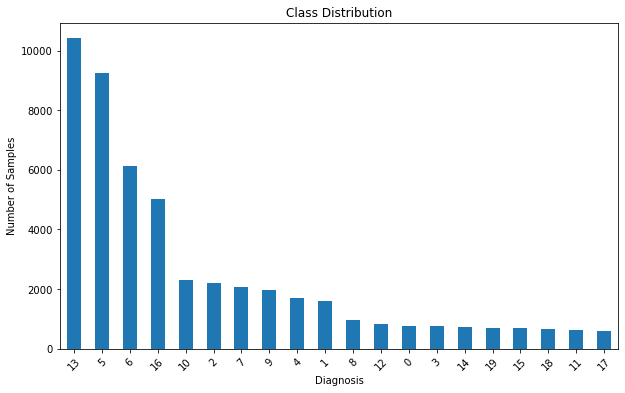

In [86]:
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [94]:
X = df.drop(columns=['Diagnosis']) 
y = df['Diagnosis']

desired_samples = {cls: 20000 for cls in range(20)}

smote = SMOTE(sampling_strategy=desired_samples, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class distribution after SMOTE with target size of 20,000 for each class:")
print(sorted(Counter(y_resampled).items()))

Class distribution after SMOTE with target size of 20,000 for each class:
[(0, 20000), (1, 20000), (2, 20000), (3, 20000), (4, 20000), (5, 20000), (6, 20000), (7, 20000), (8, 20000), (9, 20000), (10, 20000), (11, 20000), (12, 20000), (13, 20000), (14, 20000), (15, 20000), (16, 20000), (17, 20000), (18, 20000), (19, 20000)]


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [97]:
xgb_classifier = XGBClassifier(random_state=42)
xgbrf_classifier = XGBRFClassifier(random_state=42)

xgb_classifier.fit(X_train, y_train)
xgbrf_classifier.fit(X_train, y_train)

xgb_predictions = xgb_classifier.predict(X_test)
xgbrf_predictions = xgbrf_classifier.predict(X_test)

In [98]:
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgbrf_accuracy = accuracy_score(y_test, xgbrf_predictions)

xgb_precision = precision_score(y_test, xgb_predictions, average='weighted')
xgb_recall = recall_score(y_test, xgb_predictions, average='weighted')
xgb_f1 = f1_score(y_test, xgb_predictions, average='weighted')
xgb_roc_auc = roc_auc_score(y_test, xgb_classifier.predict_proba(X_test), multi_class='ovr', average='weighted')

xgbrf_precision = precision_score(y_test, xgbrf_predictions, average='weighted')
xgbrf_recall = recall_score(y_test, xgbrf_predictions, average='weighted')
xgbrf_f1 = f1_score(y_test, xgbrf_predictions, average='weighted')
xgbrf_roc_auc = roc_auc_score(y_test, xgbrf_classifier.predict_proba(X_test), multi_class='ovr', average='weighted')

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
    'XGBClassifier': [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_roc_auc],
    'XGBRFClassifier': [xgbrf_accuracy, xgbrf_precision, xgbrf_recall, xgbrf_f1, xgbrf_roc_auc]
})

metrics_df

,Metric,XGBClassifier,XGBRFClassifier
0,Accuracy,0.824263,0.653787
1,Precision,0.825266,0.662040
2,Recall,0.824263,0.653787
3,F1-score,0.824111,0.655458
4,ROC AUC,0.990924,0.943813


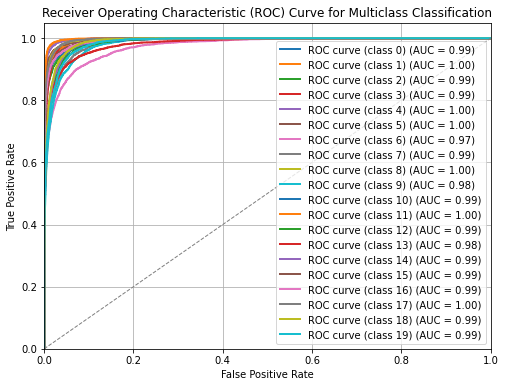

In [99]:
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], xgb_classifier.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [123]:
import pickle
from joblib import dump

dump(xgb_classifier, 'xgb_classifier.joblib')
with open('xgb_classifier.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

In [124]:
random = RandomForestClassifier(random_state=42)
random.fit(X_train, y_train)
random_predictions = random.predict(X_test)

In [126]:
accuracy = accuracy_score(y_test, random_predictions)
precision = precision_score(y_test, random_predictions, average='weighted')
recall = recall_score(y_test, random_predictions, average='weighted')
f1 = f1_score(y_test, random_predictions, average='weighted')
roc_auc = roc_auc_score(y_test, random.predict_proba(X_test), multi_class='ovr', average='weighted')

metrics_df_random = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
    'RandomForestClassifier': [accuracy, precision, recall, f1, roc_auc]
})

metrics_df_random

,Metric,RandomForestClassifier
0,Accuracy,0.954175
1,Precision,0.953845
2,Recall,0.954175
3,F1-score,0.953727
4,ROC AUC,0.998655


In [127]:
dump(random, 'random_forest_classifier.joblib')
with open('random_forest_classifier.pkl', 'wb') as f:
    pickle.dump(random, f)